In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras.layers import Dense,Input,Lambda,Concatenate
from keras.models import Model
from keras.metrics import binary_crossentropy,categorical_accuracy
import keras.backend as K
from keras.datasets import mnist
from keras.losses import categorical_crossentropy
from keras.utils import to_categorical

/home/elijahc/.pyenv/versions/3.5.2/envs/jupyterlab/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from src.models import build_dense,CachedModel

In [3]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

oh_train = to_categorical(y_train,num_classes=10)
oh_test = to_categorical(y_test,num_classes=10)

print(x_train.shape)
print(x_test.shape)
print(oh_train.shape)

(60000, 784)
(10000, 784)
(60000, 10)


In [4]:
input_shape = (784,)

enc_dim = 500
obs_dim = 10
lat_dim = 2
beta=10
inputs = Input(shape=input_shape)
encoded = build_dense(inputs,[enc_dim,enc_dim],activations='relu')
obs_y = Dense(obs_dim,activation='softmax')(encoded)
lat_z = Dense(lat_dim,activation='sigmoid')(encoded)
h = Concatenate()([obs_y,lat_z])
decoded = build_dense(h,[enc_dim,enc_dim,784],activations=['relu','relu','sigmoid'])

In [5]:
def ss_ae_loss(y_true,y_pred):
    recon_loss = K.sum(K.square(decoded-inputs))
    acc_loss = beta*categorical_crossentropy(y_true,obs_y)
    
    return K.mean(acc_loss+recon_loss)

def class_acc(y_true,y_pred):
    return categorical_accuracy(y_true,obs_y)

In [6]:
ss_ae = Model(inputs,decoded)
ss_ae.compile(optimizer='adadelta',loss=ss_ae_loss,metrics=[class_acc])

In [7]:
classifier = Model(inputs,obs_y)
classifier.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['acc'])

encoder = Model(inputs,h)
encoder.compile(loss='categorical_crossentropy',optimizer='adadelta')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 500)          392500      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 500)          250500      dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 10)           5010        dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

In [8]:
ss_ae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 500)          392500      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 500)          250500      dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 10)           5010        dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

In [9]:
ss_ae.fit(x_train,oh_train,
          batch_size=128,
          epochs=50,
          shuffle=True,
          validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 8s 154us/step - loss: 4948.4305 - class_acc: 0.4694 - val_loss: 3160.2804 - val_class_acc: 0.6057
Epoch 2/50
54000/54000 [==============================] - 8s 144us/step - loss: 2890.5397 - class_acc: 0.5657 - val_loss: 2374.1914 - val_class_acc: 0.5883
Epoch 3/50
54000/54000 [==============================] - 8s 148us/step - loss: 2309.7524 - class_acc: 0.5679 - val_loss: 2075.1772 - val_class_acc: 0.6017
Epoch 4/50
54000/54000 [==============================] - 8s 148us/step - loss: 2037.8733 - class_acc: 0.5715 - val_loss: 1941.7423 - val_class_acc: 0.6032
Epoch 5/50
54000/54000 [==============================] - 8s 148us/step - loss: 1888.7395 - class_acc: 0.5743 - val_loss: 1826.6517 - val_class_acc: 0.6160
Epoch 6/50
54000/54000 [==============================] - 8s 148us/step - loss: 1786.1223 - class_acc: 0.5794 - val_loss: 1700.8076 - val_class_acc: 0.6153
Epoch 7/50
5400

In [10]:
x_ae = ss_ae.predict(x_test,batch_size=128)
x_ae.shape
x_enc = encoder.predict(x_test,batch_size=128)

In [11]:
classifier.evaluate(x_test,oh_test,batch_size=128)

10000/10000 [==============================] - 0s 26us/step


[1.4512725673675537, 0.6337]

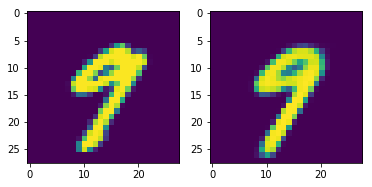

In [20]:
tidx = 20
fig,axs = plt.subplots(1,2)
axs[0].imshow(x_test[tidx].reshape(28,28))
axs[1].imshow(x_ae[tidx].reshape(28,28))

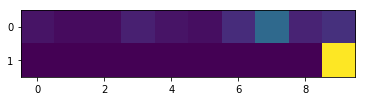

In [22]:
obs_y = x_enc[tidx][:10]
true_y = oh_test[tidx]
lat_z = x_enc[tidx][10:]
class_im = np.concatenate([obs_y.reshape(-1,1),true_y.reshape(-1,1)],axis=1)

plt.imshow(np.swapaxes(class_im,0,1))

In [23]:
print(obs_y)
print(lat_z)

[0.05298899 0.03012486 0.0296072  0.089744   0.05334315 0.03682609
 0.12721923 0.3434303  0.09970608 0.13701004]
[0.5361982 0.6743622]


In [24]:
y = x_enc[:,:10]
z = x_enc[:,10:]

(array([[ 5., 15., 12., 23., 22., 13., 30., 26., 23., 34., 31., 29., 20.,
         20., 14., 14.,  7.,  4.,  1.,  2.],
        [25., 43., 36., 31., 43., 34., 34., 47., 42., 57., 35., 45., 35.,
         25., 19., 18., 13., 10.,  6.,  2.],
        [40., 48., 46., 41., 37., 47., 46., 30., 32., 41., 43., 37., 31.,
         23., 15., 22.,  9.,  4.,  9.,  4.],
        [31., 59., 48., 48., 51., 40., 43., 55., 46., 41., 50., 28., 32.,
         33., 26., 13.,  6.,  7.,  8.,  1.],
        [42., 57., 42., 50., 50., 58., 43., 48., 46., 29., 31., 25., 31.,
         16., 19., 13., 12.,  8.,  6.,  2.],
        [31., 65., 65., 60., 56., 64., 66., 51., 39., 46., 30., 39., 33.,
         25., 24., 16., 17., 12.,  5.,  3.],
        [25., 54., 55., 60., 73., 54., 60., 50., 40., 44., 35., 26., 21.,
         27., 16., 18.,  9., 11., 10.,  5.],
        [19., 43., 48., 58., 67., 65., 65., 54., 50., 43., 30., 27., 35.,
         25., 24., 20., 10., 12., 10.,  1.],
        [21., 46., 56., 57., 41., 64., 58., 52.,

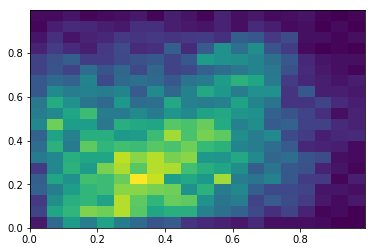

In [29]:
plt.hist2d(z[:,0],z[:,1],bins=20);